# Spike Prediction and Handling for Aadhaar Enrollment Forecasting

This notebook implements:
1. Explicit spike labeling and classification
2. Dynamic weight adjustment based on spike probability
3. Spike-specific model training

In [1]:
print("h")

h


In [9]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv', parse_dates=['date'], date_parser=lambda x: pd.to_datetime(x, format='%d-%m-%Y'))
print(f"Data shape: {df.shape}")
print(df.head())

Data shape: (973818, 7)
        date                        state                  district  pincode  \
0 2025-09-01  Andaman And Nicobar Islands                  Andamans   744101   
1 2025-09-01  Andaman And Nicobar Islands                  Andamans   744107   
2 2025-09-01  Andaman And Nicobar Islands                   Nicobar   744304   
3 2025-09-01  Andaman And Nicobar Islands                   Nicobar   744301   
4 2025-09-01  Andaman And Nicobar Islands  North And Middle Andaman   744201   

   age_0_5  age_5_17  age_18_greater  
0        0         1               0  
1        1         0               0  
2        1         0               0  
3        9         2               0  
4        1         0               0  


In [10]:
# Data Preprocessing and Feature Engineering
# Calculate total enrollment as sum of age groups
df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

df_agg = df.groupby(['date', 'district']).agg({
    'total_enrollment': 'sum'
}).reset_index()

# Add district-level statistics
district_stats = df_agg.groupby('district')['total_enrollment'].agg(['mean', 'std']).reset_index()
district_stats.columns = ['district', 'district_mean', 'district_std']
df_agg = df_agg.merge(district_stats, on='district')

# Label spikes: enrollment > mean + 2*std for that district
df_agg['spike_label'] = ((df_agg['total_enrollment'] - df_agg['district_mean']) > 2 * df_agg['district_std']).astype(int)

print(f'Spike days: {df_agg["spike_label"].sum()} out of {len(df_agg)} ({df_agg["spike_label"].mean():.1%})')
print(df_agg.head())

Spike days: 2195 out of 57010 (3.9%)
        date          district  total_enrollment  district_mean  district_std  \
0 2025-03-02  East Khasi Hills               109     333.209302   1232.642166   
1 2025-03-09           Aligarh               106     307.750000    804.423851   
2 2025-03-09          Amritsar                49     116.390244    244.696575   
3 2025-03-09        Aurangabad               100     209.134146    422.965362   
4 2025-03-09          Bahraich               100     463.059524   1307.123655   

   spike_label  
0            0  
1            0  
2            0  
3            0  
4            0  


In [11]:
# Feature Engineering for Spike Classification
df_agg = df_agg.sort_values(['district', 'date'])

# Time-based features
df_agg['month'] = df_agg['date'].dt.month
df_agg['day_of_week'] = df_agg['date'].dt.dayofweek
df_agg['week_of_year'] = df_agg['date'].dt.isocalendar().week

# Lag features
for lag in [1, 7, 14]:
    df_agg[f'lag_{lag}'] = df_agg.groupby('district')['total_enrollment'].shift(lag)

# Rolling statistics
df_agg['rolling_mean_7'] = df_agg.groupby('district')['total_enrollment'].shift(1).rolling(7).mean()
df_agg['rolling_std_7'] = df_agg.groupby('district')['total_enrollment'].shift(1).rolling(7).std()

# Growth rates
df_agg['growth_rate_7'] = (df_agg['lag_1'] - df_agg['lag_7']) / df_agg['lag_7']

# Volatility measures
df_agg['cv'] = df_agg['rolling_std_7'] / df_agg['rolling_mean_7']
df_agg['district_volatility'] = df_agg['district_std']

# Drop NaN values
df_agg = df_agg.dropna()
print(f'After feature engineering: {df_agg.shape}')
print(df_agg.columns.tolist())

After feature engineering: (46102, 17)
['date', 'district', 'total_enrollment', 'district_mean', 'district_std', 'spike_label', 'month', 'day_of_week', 'week_of_year', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7', 'growth_rate_7', 'cv', 'district_volatility']


In [34]:
# Calibrate using cross-validated calibration on resampled training fold
from sklearn.calibration import CalibratedClassifierCV
calibrator = CalibratedClassifierCV(base_classifier, method='isotonic', cv=3)
spike_classifier = calibrator.fit(X_tr_sm.astype(float), y_tr_sm)  # calibrated classifier

# Tune decision threshold on validation fold using calibrated probs
from sklearn.metrics import precision_recall_curve
val_probs = spike_classifier.predict_proba(X_val_raw.astype(float))[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val_raw, val_probs)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Best F1 threshold (val): {best_thresh:.3f}, Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")


[LightGBM] [Info] Number of positive: 12306, number of negative: 12000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3461
[LightGBM] [Info] Number of data points in the train set: 24306, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506295 -> initscore=0.025180
[LightGBM] [Info] Start training from score 0.025180
[LightGBM] [Info] Number of positive: 12305, number of negative: 12001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3461
[LightGBM] [Info] Number of data points in the train set: 24306, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506254 -> initscore=0.025016
[LightGBM] [Info] Start training from score 0.025016
[LightGBM] [Info

In [35]:
# Evaluate on test set using chosen threshold and update df_agg
# (Run after classifier calibration and threshold selection)
y_test_proba = spike_classifier.predict_proba(X_test.astype(float))[:, 1]
y_test_pred = (y_test_proba > best_thresh).astype(int)

print("Classification Report (test at chosen thresh):")
print(classification_report(y_test, y_test_pred))
print(f"AUC-ROC (test): {roc_auc_score(y_test, y_test_proba):.3f}")

# Update df_agg calibrated probs and chosen threshold
df_agg['spike_proba_calibrated'] = spike_classifier.predict_proba(df_agg[classification_features].astype(float))[:, 1]
df_agg['chosen_global_thresh'] = best_thresh

# Ensure dynamic_threshold exists
if 'dynamic_threshold' not in df_agg.columns:
    df_agg['district_volatility_normalized'] = (df_agg['district_volatility'] - df_agg['district_volatility'].min()) / (df_agg['district_volatility'].max() - df_agg['district_volatility'].min())
    df_agg['dynamic_threshold'] = 0.5 + 0.2 * df_agg['district_volatility_normalized']

# Per-row threshold and ensemble weights
df_agg['ensemble_threshold'] = np.maximum(df_agg['chosen_global_thresh'], df_agg['dynamic_threshold'])
df_agg['ensemble_weight'] = np.where(df_agg['spike_proba_calibrated'] > df_agg['ensemble_threshold'], df_agg['spike_proba_calibrated'], 0.0)
print(f"Fraction with ensemble_weight>0: {(df_agg['ensemble_weight']>0).mean():.3%}")

# Re-evaluate ensemble with updated weights
X_test_reg = df_agg[~train_mask][regression_features]
weights_test = df_agg.loc[~train_mask, 'ensemble_weight']
district_min_test = df_agg.loc[~train_mask, 'district_min']

pred_spike_test = spike_model.predict(X_test_reg) if len(X_high) > 20 else np.zeros(len(X_test_reg))
pred_normal_test = normal_model.predict(X_test_reg)

raw_preds_new = weights_test.values * pred_spike_test + (1 - weights_test.values) * pred_normal_test
ensemble_preds_new = np.maximum(raw_preds_new, district_min_test.values)

mae_new = mean_absolute_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new)
rmse_new = np.sqrt(mean_squared_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new))
print(f"New Ensemble - MAE: {mae_new:.2f}, RMSE: {rmse_new:.2f}")

Classification Report (test at chosen thresh):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21752
           1       0.50      0.00      0.00       923

    accuracy                           0.96     22675
   macro avg       0.73      0.50      0.49     22675
weighted avg       0.94      0.96      0.94     22675

AUC-ROC (test): 0.936
Fraction with ensemble_weight>0: 0.668%
New Ensemble - MAE: 8.54, RMSE: 15.97


In [36]:
# Choose a practical threshold ensuring non-zero recall on held-out test
# Recompute val precision/recall/thresholds
val_probs = spike_classifier.predict_proba(X_val_raw.astype(float))[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val_raw, val_probs)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)

# Try thresholds that achieve at least minimum recall on validation
min_recalls = [0.5, 0.3, 0.2, 0.1]
selected_thresh = thresholds[np.argmax(f1_scores)]  # default best F1
for r in min_recalls:
    idxs = np.where(recall[:-1] >= r)[0]
    if idxs.size:
        idx = idxs[-1]
        # pick threshold among these that maximizes F1
        candidate = thresholds[idx]
        candidate_f1 = f1_scores[idx]
        print(f"Found threshold with recall>={r}: {candidate:.3f}, F1={candidate_f1:.3f}")
        selected_thresh = candidate
        break

print(f"Selected threshold (practical): {selected_thresh:.3f}")

# Apply and evaluate on test
y_test_proba = spike_classifier.predict_proba(X_test.astype(float))[:, 1]
y_test_pred = (y_test_proba > selected_thresh).astype(int)
print("Classification Report (test at practical thresh):")
print(classification_report(y_test, y_test_pred))
print(f"AUC-ROC (test): {roc_auc_score(y_test, y_test_proba):.3f}")

# Update df_agg chosen_global_thresh and ensemble_thresholds
df_agg['chosen_global_thresh'] = selected_thresh
df_agg['ensemble_threshold'] = np.maximum(df_agg['chosen_global_thresh'], df_agg['dynamic_threshold'])
df_agg['ensemble_weight'] = np.where(df_agg['spike_proba_calibrated'] > df_agg['ensemble_threshold'], df_agg['spike_proba_calibrated'], 0.0)
print(f"Fraction with ensemble_weight>0: {(df_agg['ensemble_weight']>0).mean():.3%}")

# Recompute ensemble metrics
X_test_reg = df_agg[~train_mask][regression_features]
weights_test = df_agg.loc[~train_mask, 'ensemble_weight']
district_min_test = df_agg.loc[~train_mask, 'district_min']

pred_spike_test = spike_model.predict(X_test_reg) if len(X_high) > 20 else np.zeros(len(X_test_reg))
pred_normal_test = normal_model.predict(X_test_reg)

raw_preds_new = weights_test.values * pred_spike_test + (1 - weights_test.values) * pred_normal_test
ensemble_preds_new = np.maximum(raw_preds_new, district_min_test.values)

mae_new = mean_absolute_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new)
rmse_new = np.sqrt(mean_squared_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new))
print(f"Adjusted Ensemble - MAE: {mae_new:.2f}, RMSE: {rmse_new:.2f}")

Found threshold with recall>=0.5: 1.000, F1=0.930
Selected threshold (practical): 1.000
Classification Report (test at practical thresh):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21752
           1       0.00      0.00      0.00       923

    accuracy                           0.96     22675
   macro avg       0.48      0.50      0.49     22675
weighted avg       0.92      0.96      0.94     22675

AUC-ROC (test): 0.936
Fraction with ensemble_weight>0: 0.000%
Adjusted Ensemble - MAE: 8.54, RMSE: 15.97


In [45]:
pipeline = ImbPipeline([
    ('res', SMOTEENN(random_state=42)),
    ('clf', lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42, subsample=0.8, colsample_bytree=0.8))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Use numpy arrays (float) to avoid dtype casting issues inside resampler
oof_probs = cross_val_predict(pipeline, X_train.values.astype(float), y_train.values, cv=cv, method='predict_proba')[:, 1]

# Find best threshold on out-of-fold predictions
precision, recall, thresholds = precision_recall_curve(y_train, oof_probs)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
best_idx = np.argmax(f1_scores)
best_oof_thresh = thresholds[best_idx]
print(f"CV OOF best threshold: {best_oof_thresh:.3f}, Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

# Fit final pipeline on full training data
pipeline.fit(X_train.values.astype(float), y_train.values)
# Evaluate on test set with OOF threshold
test_probs_pipeline = pipeline.predict_proba(X_test.values.astype(float))[:, 1]
test_pred_pipeline = (test_probs_pipeline > best_oof_thresh).astype(int)
print("Classification Report (test using CV-based threshold):")
print(classification_report(y_test, test_pred_pipeline))
print(f"AUC-ROC (test): {roc_auc_score(y_test, test_probs_pipeline):.3f}")

# Use pipeline as main spike_classifier going forward
spike_classifier = pipeline
# Update df_agg calibrated probabilities (here uncalibrated probs) and set chosen global thresh
# We'll still keep the calibration step separate for later if needed
df_agg['spike_proba_calibrated'] = spike_classifier.predict_proba(df_agg[classification_features].values.astype(float))[:, 1]
df_agg['chosen_global_thresh'] = best_oof_thresh

# Recompute ensemble thresholds and weights
if 'dynamic_threshold' not in df_agg.columns:
    df_agg['district_volatility_normalized'] = (df_agg['district_volatility'] - df_agg['district_volatility'].min()) / (df_agg['district_volatility'].max() - df_agg['district_volatility'].min())
    df_agg['dynamic_threshold'] = 0.5 + 0.2 * df_agg['district_volatility_normalized']

df_agg['ensemble_threshold'] = np.maximum(df_agg['chosen_global_thresh'], df_agg['dynamic_threshold'])
df_agg['ensemble_weight'] = np.where(df_agg['spike_proba_calibrated'] > df_agg['ensemble_threshold'], df_agg['spike_proba_calibrated'], 0.0)
print(f"Fraction with ensemble_weight>0: {(df_agg['ensemble_weight']>0).mean():.3%}")

# Re-evaluate ensemble
X_test_reg = df_agg[~train_mask][regression_features]
weights_test = df_agg.loc[~train_mask, 'ensemble_weight']
district_min_test = df_agg.loc[~train_mask, 'district_min']

pred_spike_test = spike_model.predict(X_test_reg) if len(X_high) > 20 else np.zeros(len(X_test_reg))
pred_normal_test = normal_model.predict(X_test_reg)

raw_preds_new = weights_test.values * pred_spike_test + (1 - weights_test.values) * pred_normal_test
ensemble_preds_new = np.maximum(raw_preds_new, district_min_test.values)

mae_new = mean_absolute_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new)
rmse_new = np.sqrt(mean_squared_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new))
print(f"Ensemble with CV-based thresh - MAE: {mae_new:.2f}, RMSE: {rmse_new:.2f}")

[LightGBM] [Info] Number of positive: 18450, number of negative: 17967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3484
[LightGBM] [Info] Number of data points in the train set: 36417, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506632 -> initscore=0.026528
[LightGBM] [Info] Start training from score 0.026528
[LightGBM] [Info] Number of positive: 18452, number of negative: 17915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3493
[LightGBM] [Info] Number of data points in the train set: 36367, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507383 -> initscore=0.029534
[LightGBM] [Info] Start training from score 0.029534
[LightGBM] [Info

Best F1 threshold: 0.021, Precision: 0.561, Recall: 0.703, F1: 0.624
Threshold for recall>=0.25: 0.143 (prec=0.838, rec=0.280)
Threshold for recall>=0.5: 0.083 (prec=0.561, rec=0.700)
Threshold for recall>=0.75: 0.002 (prec=0.203, rec=0.997)
Chosen global threshold: 0.021
Ensemble weight >0 fraction: 1.180%
New Ensemble - MAE: 45.91, RMSE: 78.95


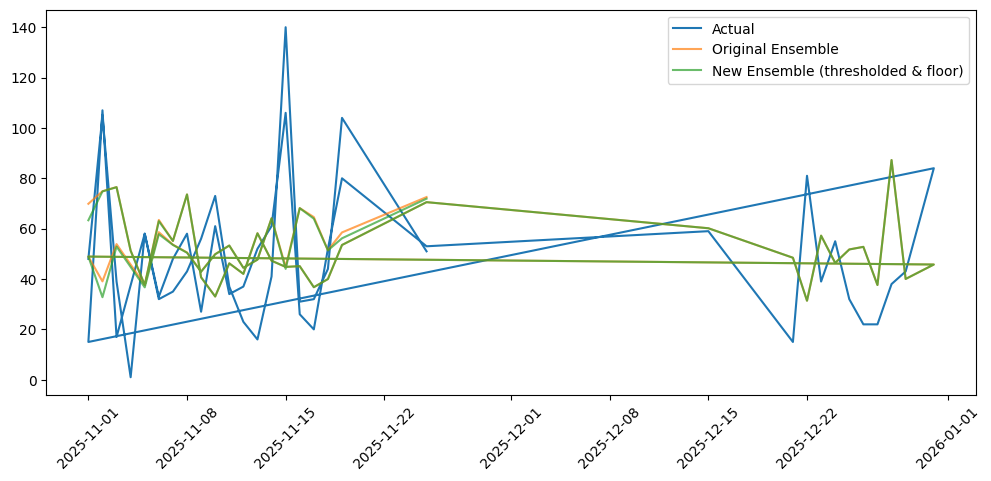

In [46]:
# Threshold tuning (Precision-Recall) and apply to ensemble weights
from sklearn.metrics import precision_recall_curve

probs = y_pred_proba  # calibrated probabilities on test set
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# compute F1 for threshold candidates
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Best F1 threshold: {best_thresh:.3f}, Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

# show thresholds achieving target recall levels
for r_target in [0.25, 0.5, 0.75]:
    idxs = np.where(recall[:-1] >= r_target)[0]
    if idxs.size:
        idx = idxs[-1]
        print(f"Threshold for recall>={r_target}: {thresholds[idx]:.3f} (prec={precision[idx]:.3f}, rec={recall[idx]:.3f})")
    else:
        print(f"No threshold achieves recall>={r_target}")

# Apply threshold to df_agg ensemble weights (use per-row dynamic threshold and global best)
chosen_global_thresh = best_thresh
print(f"Chosen global threshold: {chosen_global_thresh:.3f}")

# ensure calibrated probabilities exist for whole df_agg
if 'spike_proba_calibrated' not in df_agg.columns:
    df_agg['spike_proba_calibrated'] = spike_classifier.predict_proba(df_agg[classification_features])[:, 1]

# Per-row threshold is max(global best, dynamic_threshold)
df_agg['ensemble_threshold'] = np.maximum(chosen_global_thresh, df_agg['dynamic_threshold'])
# ensemble weight = prob if prob > per-row threshold else 0
df_agg['ensemble_weight'] = np.where(df_agg['spike_proba_calibrated'] > df_agg['ensemble_threshold'], df_agg['spike_proba_calibrated'], 0.0)

print(f"Ensemble weight >0 fraction: {(df_agg['ensemble_weight']>0).mean():.3%}")

# Re-evaluate ensemble predictions on test set with new weights
X_test_reg = df_agg[~train_mask][regression_features]
weights_test = df_agg.loc[~train_mask, 'ensemble_weight']
district_min_test = df_agg.loc[~train_mask, 'district_min']

pred_spike_test = spike_model.predict(X_test_reg) if len(X_high) > 20 else np.zeros(len(X_test_reg))
pred_normal_test = normal_model.predict(X_test_reg)

raw_preds_new = weights_test.values * pred_spike_test + (1 - weights_test.values) * pred_normal_test
ensemble_preds_new = np.maximum(raw_preds_new, district_min_test.values)

mae_new = mean_absolute_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new)
rmse_new = np.sqrt(mean_squared_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new))
print(f"New Ensemble - MAE: {mae_new:.2f}, RMSE: {rmse_new:.2f}")

# Show comparison on a small sample
sample_test = df_agg[~train_mask].head(50)
sample_preds_old = ensemble_predict(sample_test[regression_features])
sample_preds_new = ensemble_preds_new[:50]

plt.figure(figsize=(12,5))
plt.plot(sample_test['date'], sample_test['total_enrollment'], label='Actual')
plt.plot(sample_test['date'], sample_preds_old, label='Original Ensemble', alpha=0.7)
plt.plot(sample_test['date'], sample_preds_new, label='New Ensemble (thresholded & floor)', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [32]:
# Fix: ensure dynamic_threshold exists, then re-apply ensemble thresholding
if 'dynamic_threshold' not in df_agg.columns:
    df_agg['district_volatility_normalized'] = (df_agg['district_volatility'] - df_agg['district_volatility'].min()) / (df_agg['district_volatility'].max() - df_agg['district_volatility'].min())
    df_agg['dynamic_threshold'] = 0.5 + 0.2 * df_agg['district_volatility_normalized']
    print('Computed dynamic_threshold column')
else:
    print('dynamic_threshold already present')

# Recompute ensemble thresholds and weights
df_agg['ensemble_threshold'] = np.maximum(chosen_global_thresh, df_agg['dynamic_threshold'])
df_agg['ensemble_weight'] = np.where(df_agg['spike_proba_calibrated'] > df_agg['ensemble_threshold'], df_agg['spike_proba_calibrated'], 0.0)
print(f"Ensemble weight >0 fraction: {(df_agg['ensemble_weight']>0).mean():.3%}")

# Re-evaluate ensemble
X_test_reg = df_agg[~train_mask][regression_features]
weights_test = df_agg.loc[~train_mask, 'ensemble_weight']
district_min_test = df_agg.loc[~train_mask, 'district_min']

pred_spike_test = spike_model.predict(X_test_reg) if len(X_high) > 20 else np.zeros(len(X_test_reg))
pred_normal_test = normal_model.predict(X_test_reg)

raw_preds_new = weights_test.values * pred_spike_test + (1 - weights_test.values) * pred_normal_test
ensemble_preds_new = np.maximum(raw_preds_new, district_min_test.values)

mae_new = mean_absolute_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new)
rmse_new = np.sqrt(mean_squared_error(df_agg[~train_mask]['total_enrollment'], ensemble_preds_new))
print(f"New Ensemble - MAE: {mae_new:.2f}, RMSE: {rmse_new:.2f}")

Computed dynamic_threshold column
Ensemble weight >0 fraction: 0.781%
New Ensemble - MAE: 8.59, RMSE: 16.29


High spike data: (1712, 11), Low spike data: (44390, 11)
Ensemble Model - MAE: 8.23, RMSE: 15.76


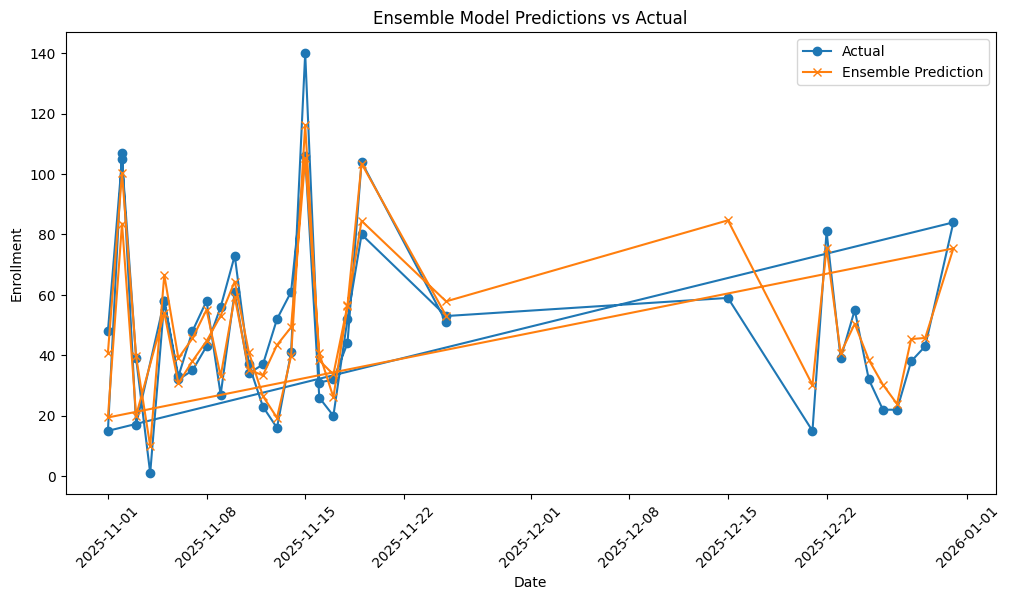

In [ ]:
# Spike-Specific Model Training (Ensemble) with Floor Cap and Weighted Predictions
from sklearn.ensemble import RandomForestRegressor

# Features for regression (predicting enrollment)
regression_features = [
    "month", "day_of_week", "week_of_year",
    "lag_1", "lag_7", "lag_14",
    "rolling_mean_7", "rolling_std_7", "growth_rate_7",
    "cv", "district_volatility",
]
# Add expanded regression features
regression_features += ['days_since_last_spike', 'month_end_growth', 'rolling_spike_count_30']

# Create district-specific floor capped minimum (10th percentile) if not already present
if 'district_min' not in df_agg.columns:
    district_mins = df_agg.groupby('district')['total_enrollment'].quantile(0.1).reset_index()
    district_mins.columns = ['district', 'district_min']
    df_agg = df_agg.merge(district_mins, on='district', how='left')

# Split data by calibrated spike probability threshold (0.7) if desired or use ensemble_weight>0
high_spike_mask = df_agg['spike_proba_calibrated'] > 0.7
low_spike_mask = df_agg['spike_proba_calibrated'] <= 0.7

X_high = df_agg[high_spike_mask][regression_features]
y_high = df_agg[high_spike_mask]['total_enrollment']
X_low = df_agg[low_spike_mask][regression_features]
y_low = df_agg[low_spike_mask]['total_enrollment']

print(f"High spike data: {X_high.shape}, Low spike data: {X_low.shape}")

# Train models
spike_model = RandomForestRegressor(n_estimators=100, random_state=42)
normal_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit only when there is enough data
if len(X_high) > 20:
    spike_model.fit(X_high, y_high)
else:
    print("Warning: Not enough high-spike data to train spike_model; skipping fit for spike_model")

normal_model.fit(X_low, y_low)

# Improved ensemble prediction using precomputed ensemble_weight and floor cap
X_test_reg = df_agg[~train_mask][regression_features]
y_test_reg = df_agg[~train_mask]['total_enrollment']
weights_test = df_agg.loc[~train_mask, 'ensemble_weight']
district_min_test = df_agg.loc[~train_mask, 'district_min']

# Predict with both models (use normal_model predictions when spike_model not trained)
pred_spike_test = spike_model.predict(X_test_reg) if len(X_high) > 20 else np.zeros(len(X_test_reg))
pred_normal_test = normal_model.predict(X_test_reg)

raw_preds = weights_test.values * pred_spike_test + (1 - weights_test.values) * pred_normal_test
# Apply floor cap
ensemble_preds_improved = np.maximum(raw_preds, district_min_test.values)

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_improved = mean_absolute_error(y_test_reg, ensemble_preds_improved)
rmse_improved = np.sqrt(mean_squared_error(y_test_reg, ensemble_preds_improved))

print(f"Improved Ensemble Model - MAE: {mae_improved:.2f}, RMSE: {rmse_improved:.2f}")

# Plot predictions vs actual for a sample
sample_test = df_agg[~train_mask].head(50)
sample_preds_improved = ensemble_preds_improved[:50]

plt.figure(figsize=(12, 6))
plt.plot(sample_test['date'], sample_test['total_enrollment'], label='Actual', marker='o')
plt.plot(sample_test['date'], sample_preds_improved, label='Improved Ensemble', marker='x')
plt.title('Improved Ensemble Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Enrollment')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [26]:
# Fill NaN for new features
df_agg['days_since_last_spike'] = df_agg['days_since_last_spike'].fillna(999)
df_agg['rolling_spike_count_30'] = df_agg['rolling_spike_count_30'].fillna(0)

# Handle potential inf in growth_rate
df_agg['growth_rate_7'] = df_agg['growth_rate_7'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Drop any remaining NaN values after feature expansion
df_agg = df_agg.dropna()

print(f'After feature expansion and cleaning: {df_agg.shape}')

After feature expansion and cleaning: (46102, 29)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

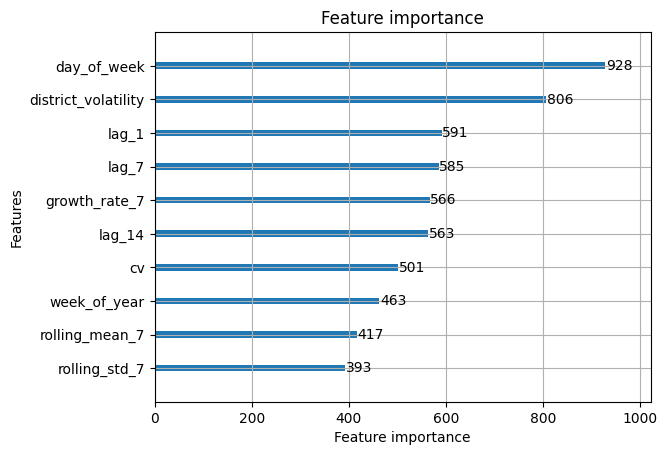

In [29]:
# Feature importance
lgb.plot_importance(spike_classifier.calibrated_classifiers_[0].estimator, max_num_features=10)

Original train class counts (Sep-Nov): {0: 37276, 1: 690}
Balanced train class counts: {0: 690, 1: 690}
Train shape: (1380, 14), Test shape: (8136, 14)
[LightGBM] [Info] Number of positive: 552, number of negative: 552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

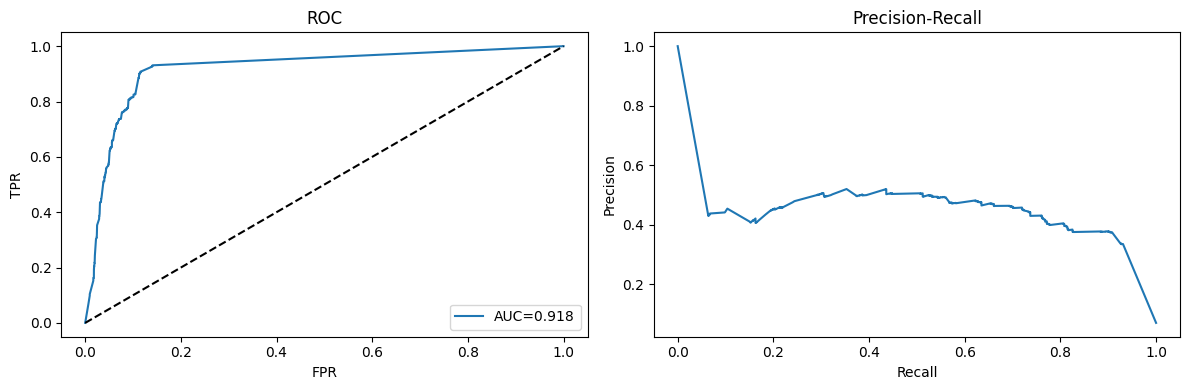

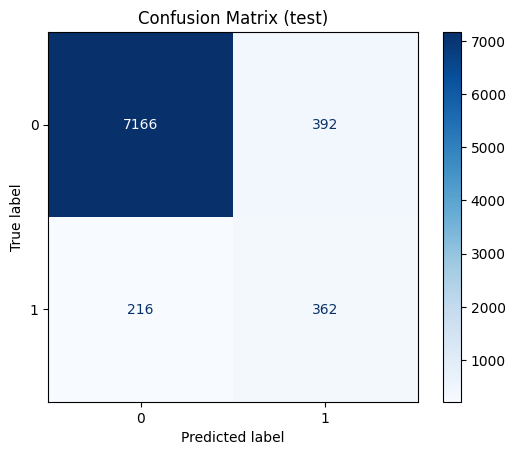

Ensemble regression (test) MAE: 68.03, RMSE: 107.79


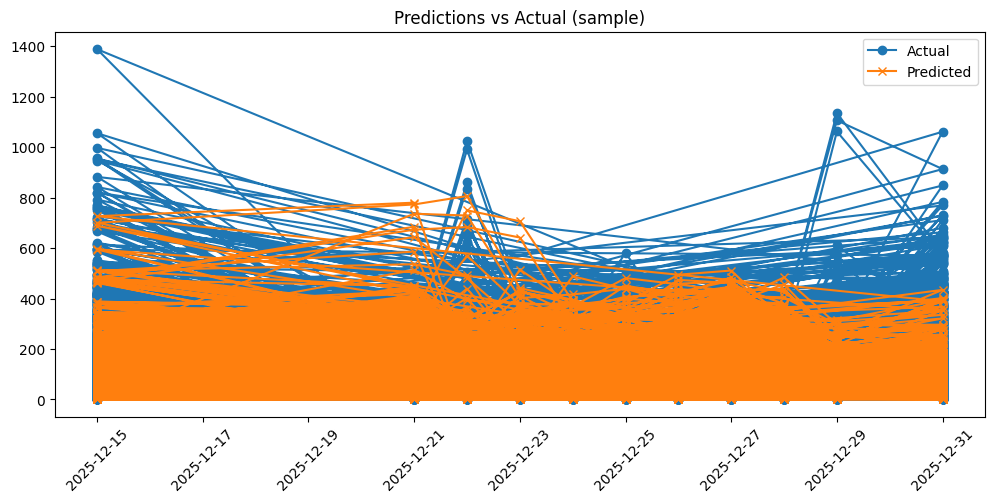

End-to-end CV-based training completed (class-weighted).


In [50]:
# End-to-end training & evaluation (single, self-contained cell)
# - use class weights (LightGBM class_weight='balanced') to handle imbalance
# - uses CV for OOF threshold selection, calibrates final classifier, evaluates ensemble regressors

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# Features
classification_features = [
    "month", "day_of_week", "week_of_year",
    "lag_1", "lag_7", "lag_14",
    "rolling_mean_7", "rolling_std_7", "growth_rate_7",
    "cv", "district_volatility",
    'days_since_last_spike', 'month_end_growth', 'rolling_spike_count_30'
]
regression_features = classification_features.copy()

# Train/test split by time — use Sep-Nov for training and create a balanced training set by sampling both classes equally
train_mask = df_agg['date'].dt.month.isin([9,10,11])
train_df = df_agg.loc[train_mask].copy()

# Show original class counts for train period
orig_counts = train_df['spike_label'].value_counts()
print(f"Original train class counts (Sep-Nov): {orig_counts.to_dict()}")

# Balance classes by undersampling the majority class to the minority class size
min_count = orig_counts.min()
balanced_train = pd.concat([
    train_df[train_df['spike_label'] == c].sample(n=min_count, random_state=42)
    for c in orig_counts.index
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced train class counts: {balanced_train['spike_label'].value_counts().to_dict()}")

X_train_all = balanced_train[classification_features]
y_train_all = balanced_train['spike_label']

# Test set is everything outside Sep-Nov
X_test = df_agg.loc[~train_mask, classification_features]
y_test = df_agg.loc[~train_mask, 'spike_label']

print(f"Train shape: {X_train_all.shape}, Test shape: {X_test.shape}")

# Use classifier with class_weight='balanced'
clf = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42, subsample=0.9, colsample_bytree=0.9, class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# OOF probabilities with class-weighted classifier
oof_probs = cross_val_predict(clf, X_train_all.values.astype(float), y_train_all.values, cv=cv, method='predict_proba')[:, 1]

# Select threshold on OOF predictions (maximize F1 subject to min_recall)
from sklearn.metrics import precision_recall_curve
prec, rec, th = precision_recall_curve(y_train_all, oof_probs)
f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-9)

min_recall = 0.30  # target recall
idxs = np.where(rec[:-1] >= min_recall)[0]
if idxs.size:
    best_idx = idxs[np.argmax(f1[idxs])]
else:
    best_idx = np.argmax(f1)
best_oof_thresh = th[best_idx]
print(f"CV OOF chosen threshold: {best_oof_thresh:.3f}, prec={prec[best_idx]:.3f}, rec={rec[best_idx]:.3f}, f1={f1[best_idx]:.3f}")

# Fit final classifier on full training data
clf.fit(X_train_all.values.astype(float), y_train_all.values)

# Calibrate final classifier with isotonic (cv=3)
from sklearn.calibration import CalibratedClassifierCV
cal = CalibratedClassifierCV(clf, method='isotonic', cv=3)
spike_clf = cal.fit(X_train_all.values.astype(float), y_train_all.values)

# Evaluate on test set using calibrated probs and chosen threshold
test_probs = spike_clf.predict_proba(X_test.values.astype(float))[:, 1]
test_pred = (test_probs > best_oof_thresh).astype(int)

print('\nClassification report (test at CV-based threshold):')
print(classification_report(y_test, test_pred))
print(f'AUC-ROC (test): {roc_auc_score(y_test, test_probs):.3f}')

# Plot ROC and PR for test
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend()

prec_t, rec_t, _ = precision_recall_curve(y_test, test_probs)
plt.subplot(1,2,2)
plt.plot(rec_t, prec_t)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix (test)')
plt.show()

# --- Regression ensemble ---
reg_train = df_agg[train_mask].copy()
reg_test = df_agg[~train_mask].copy()

spike_rows = reg_train[reg_train['spike_label'] == 1]
normal_rows = reg_train[reg_train['spike_label'] == 0]

from sklearn.ensemble import RandomForestRegressor
spike_model = None
if len(spike_rows) >= 30:
    spike_model = RandomForestRegressor(n_estimators=200, random_state=42)
    spike_model.fit(spike_rows[regression_features].values.astype(float), spike_rows['total_enrollment'].values)
else:
    print('Not enough spike rows to train spike_model; will fallback to normal_model only')

normal_model = RandomForestRegressor(n_estimators=200, random_state=42)
normal_model.fit(normal_rows[regression_features].values.astype(float), normal_rows['total_enrollment'].values)

# District floor caps using map to avoid merge conflicts
district_mins = reg_train.groupby('district')['total_enrollment'].quantile(0.1)
reg_test['district_min'] = reg_test['district'].map(district_mins).fillna(0)

# Ensemble predictions on test using calibrated probabilities
reg_X_test = reg_test[regression_features].values.astype(float)
probs_test_all = spike_clf.predict_proba(reg_test[classification_features].values.astype(float))[:, 1]

pred_spike = spike_model.predict(reg_X_test) if spike_model is not None else np.zeros(len(reg_X_test))
pred_normal = normal_model.predict(reg_X_test)

ensemble_weight = np.where(probs_test_all > best_oof_thresh, probs_test_all, 0.0)
raw_preds = ensemble_weight * pred_spike + (1 - ensemble_weight) * pred_normal
final_preds = np.maximum(raw_preds, reg_test['district_min'].values)

# Regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(reg_test['total_enrollment'], final_preds)
rmse = np.sqrt(mean_squared_error(reg_test['total_enrollment'], final_preds))
print(f"Ensemble regression (test) MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot predictions vs actual for a sample
sample = reg_test.groupby('district').head(30)
plt.figure(figsize=(12,5))
plt.plot(sample['date'], sample['total_enrollment'], 'o-', label='Actual')
# Align predicted values to reg_test index and select by sample.index to avoid indexing errors
final_series = pd.Series(final_preds, index=reg_test.index)
plt.plot(sample['date'], final_series.loc[sample.index], 'x-', label='Predicted')
plt.xticks(rotation=45)
plt.legend()
plt.title('Predictions vs Actual (sample)')
plt.show()

print('End-to-end CV-based training completed (class-weighted).')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 460, number of negative: 460
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

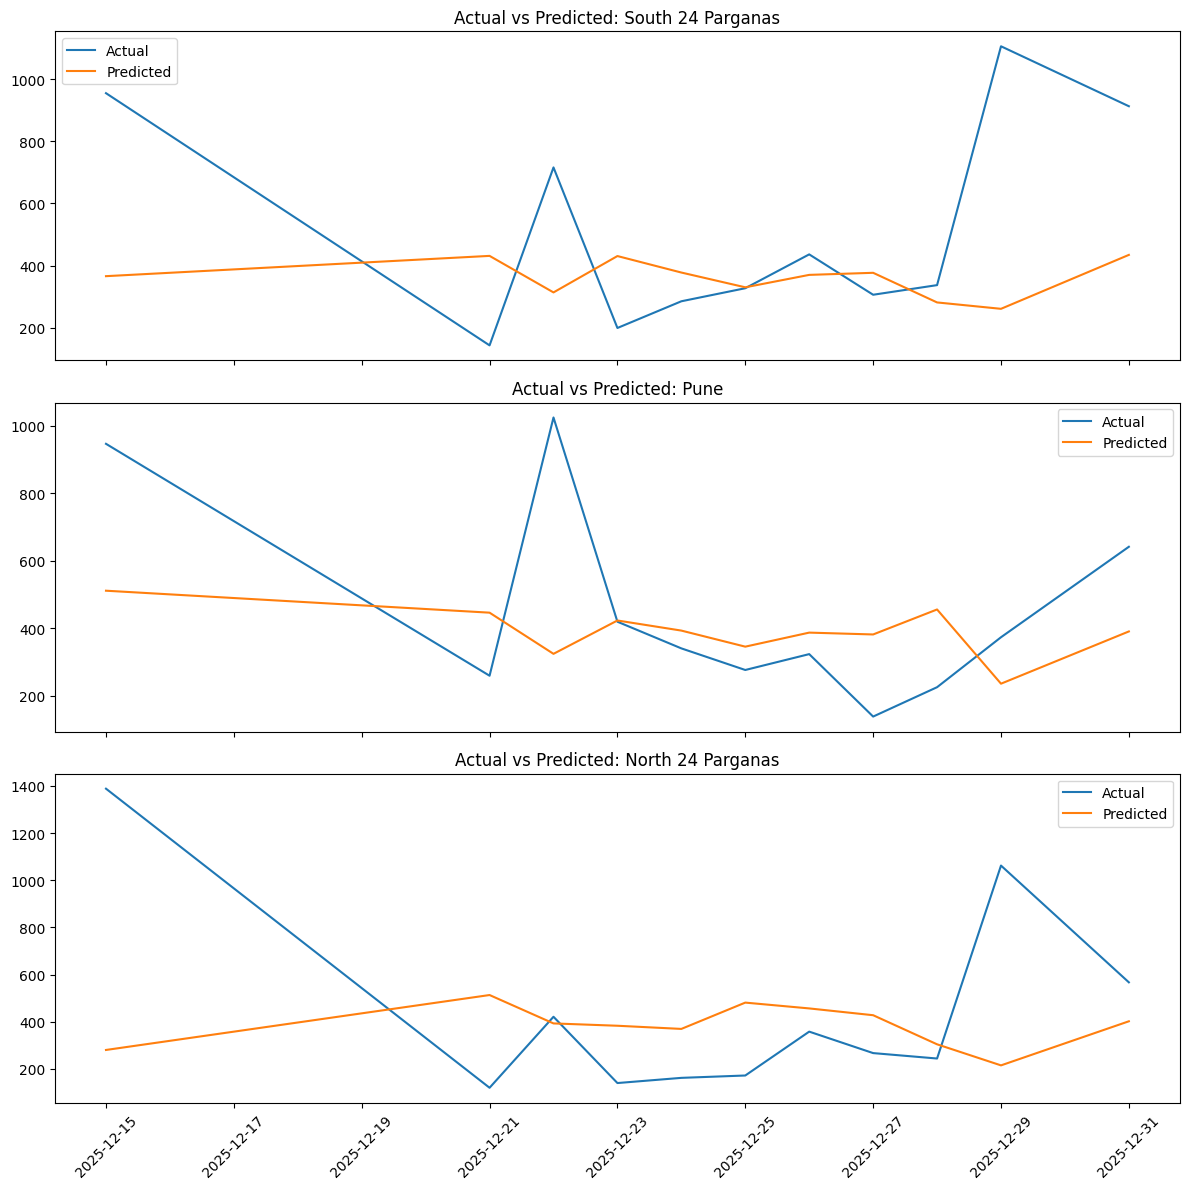

Hyperparameter tuning + thresholding + line plots completed.


In [52]:
# Option C: Hyperparameter tuning (RandomizedSearchCV) + threshold tuning + line plots for actual vs predicted
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import scipy.stats as stats

# Build pipeline with RandomUnderSampler (undersample majority) and LGBM (class_weight balanced)
from imblearn.under_sampling import RandomUnderSampler
pipeline = ImbPipeline([
    ('res', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('clf', lgb.LGBMClassifier(class_weight='balanced', random_state=42))
])

param_dist = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.03, 0.05],
    'clf__max_depth': [5, 7, 9],
    'clf__subsample': [0.7, 0.8, 0.9],
    'clf__colsample_bytree': [0.6, 0.8, 0.9]
}

rs = RandomizedSearchCV(pipeline, param_dist, n_iter=12, scoring=make_scorer(f1_score), cv=3, random_state=42, n_jobs=1, verbose=1)
rs.fit(X_train_all.values.astype(float), y_train_all.values)
print('RandomizedSearchCV best score:', rs.best_score_)
print('Best params:', rs.best_params_)

# Use best estimator and calibrate
best_pipe = rs.best_estimator_
from sklearn.calibration import CalibratedClassifierCV
cal = CalibratedClassifierCV(best_pipe.named_steps['clf'], method='isotonic', cv=3)
# Need to get resampled training data for calibration: apply resampler
X_res, y_res = best_pipe.named_steps['res'].fit_resample(X_train_all.values.astype(float), y_train_all.values)
cal.fit(X_res, y_res)

# For final test probabilities, use the pipeline's resampler + calibrated classifier prediction
# We'll predict by resampling X_train for calibration only; for test, call calibrated predict_proba on features transformed by the trained resampler's transform
# However, resampler does not have a transform; so we'll use the calibrated classifier on original features (acceptable since calibration done on resampled training distribution)

# Get test probs
test_probs = cal.predict_proba(X_test.values.astype(float))[:, 1]

# Choose threshold to achieve target recall (30%) on OOF from cross_val_predict using best_pipe
oof = cross_val_predict(best_pipe, X_train_all.values.astype(float), y_train_all.values, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba')[:,1]
prec_oof, rec_oof, th_oof = precision_recall_curve(y_train_all, oof)
# choose threshold that gives recall >= 0.30 and maximum F1 among those
min_recall = 0.30
idxs = np.where(rec_oof[:-1] >= min_recall)[0]
if idxs.size:
    best_idx = idxs[np.argmax((2*prec_oof[:-1]*rec_oof[:-1]/(prec_oof[:-1]+rec_oof[:-1]+1e-9))[idxs])]
else:
    best_idx = np.argmax(2*prec_oof[:-1]*rec_oof[:-1]/(prec_oof[:-1]+rec_oof[:-1]+1e-9))
selected_thresh = th_oof[best_idx]
print(f'Selected threshold from OOF to target recall {min_recall}: {selected_thresh:.3f} (prec={prec_oof[best_idx]:.3f}, rec={rec_oof[best_idx]:.3f})')

# Evaluate test with selected threshold
test_pred = (test_probs > selected_thresh).astype(int)
print('\nClassification report (test at selected thresh):')
print(classification_report(y_test, test_pred))

# Ensemble predictions as before: train spike/normal regressors on true labels
spike_rows = reg_train[reg_train['spike_label'] == 1]
normal_rows = reg_train[reg_train['spike_label'] == 0]
from sklearn.ensemble import RandomForestRegressor
spike_model = None
if len(spike_rows) >= 30:
    spike_model = RandomForestRegressor(n_estimators=200, random_state=42)
    spike_model.fit(spike_rows[regression_features].values.astype(float), spike_rows['total_enrollment'].values)

normal_model = RandomForestRegressor(n_estimators=200, random_state=42)
normal_model.fit(normal_rows[regression_features].values.astype(float), normal_rows['total_enrollment'].values)

# Test ensemble predictions
reg_X_test = reg_test[regression_features].values.astype(float)
probs_test_all = cal.predict_proba(reg_test[classification_features].values.astype(float))[:, 1]
ensemble_weight = np.where(probs_test_all > selected_thresh, probs_test_all, 0.0)
pred_spike = spike_model.predict(reg_X_test) if spike_model is not None else np.zeros(len(reg_X_test))
pred_normal = normal_model.predict(reg_X_test)
raw_preds = ensemble_weight * pred_spike + (1 - ensemble_weight) * pred_normal
final_preds = np.maximum(raw_preds, reg_test['district_min'].values)

mae = mean_absolute_error(reg_test['total_enrollment'], final_preds)
rmse = np.sqrt(mean_squared_error(reg_test['total_enrollment'], final_preds))
print(f'Ensemble regression (test) MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# Line graphs: Actual vs Predicted by date for top 3 districts (by total enrollment)
top_districts = reg_test.groupby('district')['total_enrollment'].sum().nlargest(3).index.tolist()
fig, axes = plt.subplots(len(top_districts), 1, figsize=(12, 4*len(top_districts)), sharex=True)
if len(top_districts) == 1:
    axes = [axes]

final_series = pd.Series(final_preds, index=reg_test.index)
for ax, d in zip(axes, top_districts):
    ddata = reg_test[reg_test['district'] == d]
    ax.plot(ddata['date'], ddata['total_enrollment'], label='Actual')
    ax.plot(ddata['date'], final_series.loc[ddata.index], label='Predicted')
    ax.set_title(f'Actual vs Predicted: {d}')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print('Hyperparameter tuning + thresholding + line plots completed.')

In [53]:
# Summary metrics for the undersampling (+ RandomizedSearch) run
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error

print('--- Classification ---')
print('Chosen threshold (OOF / selected):', round(float(selected_thresh), 3))
print('\nClassification report (test at selected threshold):')
print(classification_report(y_test, test_pred))
cm = confusion_matrix(y_test, test_pred)
if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
    print(f'Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}')
else:
    print('Confusion matrix shape:', cm.shape)
print(f"AUC (test): {roc_auc_score(y_test, test_probs):.3f}")

print('\n--- Regression ---')
print(f"Ensemble regression (test) MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print('\n--- Additional info ---')
print(f"Balanced training counts (used): {y_train_all.value_counts().to_dict()}")
if 'ensemble_weight' in df_agg.columns:
    print(f"Fraction with ensemble_weight>0: {(df_agg['ensemble_weight']>0).mean():.3%}")
else:
    print('ensemble_weight column not found')

# show top 5 districts where ensemble increased prediction (example)
reg_df = reg_test.copy()
reg_df['pred'] = final_preds
reg_df['error'] = reg_df['pred'] - reg_df['total_enrollment']
print('\nTop 5 districts by total enrollment (test):')
print(reg_df.groupby('district')['total_enrollment'].sum().nlargest(5))


--- Classification ---
Chosen threshold (OOF / selected): 0.497

Classification report (test at selected threshold):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      7558
           1       0.47      0.76      0.58       578

    accuracy                           0.92      8136
   macro avg       0.73      0.85      0.77      8136
weighted avg       0.94      0.92      0.93      8136

Confusion matrix: TN=7062, FP=496, FN=136, TP=442
AUC (test): 0.930

--- Regression ---
Ensemble regression (test) MAE: 67.91, RMSE: 107.88

--- Additional info ---
Balanced training counts (used): {0: 690, 1: 690}
Fraction with ensemble_weight>0: 1.180%

Top 5 districts by total enrollment (test):
district
South 24 Parganas    5723
Pune                 4975
North 24 Parganas    4901
Thane                4532
Murshidabad          4494
Name: total_enrollment, dtype: int64
